# NGS. HW2
Илья Шешуков

## Часть 1. Анализ ридов Illumina
### 0. Разбораться с Bowtie2 / bwa mem


```shell
$ bwa index data/ref.fasta.gz
[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.55 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 0.32 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ref.fasta.gz
[main] Real time: 3.029 sec; CPU: 1.990 sec

$ bwa mem data/ref.fasta.gz data/frag.R1.fastq.gz data/frag.R2.fastq.gz > frag.sam
[...]

$ samtools flagstat frag.sam
3432529 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
165 + 0 supplementary
0 + 0 duplicates
3424657 + 0 mapped (99.77% : N/A)
3432364 + 0 paired in sequencing
1716182 + 0 read1
1716182 + 0 read2
3407384 + 0 properly paired (99.27% : N/A)
3416620 + 0 with itself and mate mapped
7872 + 0 singletons (0.23% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ bwa mem data/ref.fasta.gz data/jump.R1.fastq.gz data/jump.R2.fastq.gz > jump.sam
[...]

$ samtools flagstat jump.sam
4328969 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
13369 + 0 supplementary
0 + 0 duplicates
4279501 + 0 mapped (98.86% : N/A)
4315600 + 0 paired in sequencing
2157800 + 0 read1
2157800 + 0 read2
3764298 + 0 properly paired (87.23% : N/A)
4216854 + 0 with itself and mate mapped
49278 + 0 singletons (1.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```
### 1. Покрытие генома

``` shell
$ samtools sort -o frag.sorted frag.sam
[bam_sort_core] merging from 1 files and 1 in-memory blocks...

$ samtools index frag.sorted
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import pysam
from itertools import zip_longest, islice
import pysamstats
from Bio import SeqIO
import gzip

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

Avg coverage 129.93298393959955
Genome covered 100.0%


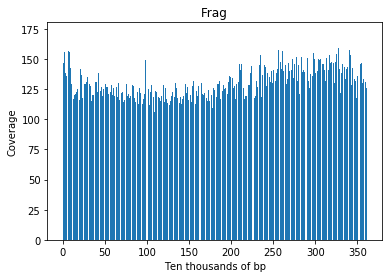

In [2]:
coverages = []
samfile = pysam.AlignmentFile("work/frag.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.bar(list(range(0, len(coverages))), coverages)
plt.title("Frag")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

Avg coverage 132.5870349332601
Genome covered 83.1343148572154%


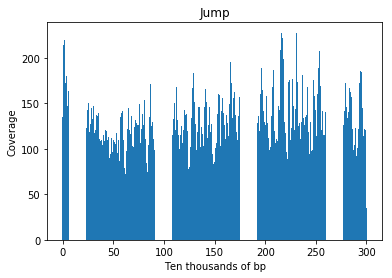

In [4]:
coverages = []
samfile = pysam.AlignmentFile("work/jump.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.n for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.bar(list(range(0, len(coverages))), coverages)
plt.title("Jump")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

### 2. Распределение расстояния вставки.

Mean: 6.928599583572345
Std:  63220.64621776202
95 percentile:  716.0


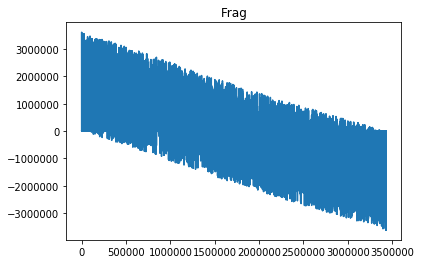

In [3]:
samfile = pysam.AlignmentFile("work/frag.sorted", "rb")
inserts = np.array(
        [read.tlen for read in samfile])
insert_mean, insert_std = np.mean(inserts), np.std(inserts)    
samfile.close()

print(f'Mean: {insert_mean}')
print(f'Std:  {insert_std}')
print(f'95 percentile:  {np.percentile(inserts, 95) - np.percentile(inserts, 5)}')
plt.plot(inserts)
plt.title('Frag')
plt.show()

Mean: 17.384137654947402
Std:  474828.84810359066
95 percentile:  20166.0


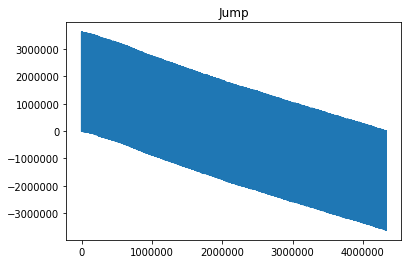

In [4]:
samfile = pysam.AlignmentFile("work/jump.sorted", "rb")
inserts = np.array(
        [read.tlen for read in samfile])
insert_mean, insert_std = np.mean(inserts), np.std(inserts)    
samfile.close()

print(f'Mean: {insert_mean}')
print(f'Std:  {insert_std}')
print(f'95 percentile:  {np.percentile(inserts, 95) - np.percentile(inserts, 5)}')
plt.plot(inserts)
plt.title('Jump')
plt.show()

### 3. Частоты различных замен

In [ ]:
df = pd.DataFrame(index=['A','C','G','T'], columns=['A', 'C', 'G', 'T'])
df[:] = 0

ref = ""
with gzip.open('work/data/ref.fasta.gz', "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        ref += str(record.seq)

samfile = pysam.AlignmentFile("work/frag.sorted", "rb")

avgs = []
for read in samfile:
    for x, y in zip(ref[read.reference_start:read.reference_start+read.query_length], read.query_sequence):
        if x != y:
            try:
                df.loc[x, y] += 1
            except:
                pass
        
    if read.has_tag('NM'):
        avgs.append(read.get_tag('NM')/read.infer_read_length())
        
print(f'Avg error rate: {np.mean(avgs)}')
    
print(df)
samfile.close()


In [ ]:
df = pd.DataFrame(index=['A','C','G','T'], columns=['A', 'C', 'G', 'T'])
df[:] = 0

ref = ""
with gzip.open('work/data/ref.fasta.gz', "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        ref += str(record.seq)

samfile = pysam.AlignmentFile("work/jump.sorted", "rb")

avgs = []
for read in samfile:
    for x, y in zip(ref[read.reference_start:read.reference_start+read.query_length], read.query_sequence):
        if x != y:
            try:
                df.loc[x, y] += 1
            except:
                pass
        
    if read.has_tag('NM'):
        avgs.append(read.get_tag('NM')/read.infer_read_length())
        
print(f'Avg error rate: {np.mean(avgs)}')
    
print(df)
samfile.close()


In [5]:
# Часть 2: анализ ридов IonTorrent